# Scraping Notícias

In [1]:
# Importar bibliotecas
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
# Carregar base com as urls
urls = pd.read_excel('/content/urls.xlsx', sheet_name ='acritica')

In [5]:
# Scraping das notícias
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

linkMateria = []
tituloMateria = []
subTituloMateria = []
dataPublicacao = []
corpoMateria = [] 

for url in urls['urls']:
  try:

    req = requests.get(url)
    if req.status_code == 200 or 403:
      soup = BeautifulSoup(requests.get(url, headers=headers).content, "html.parser")
      publicado = soup.find('span',class_="styled__Span-sc-fdx3oi-7 fNeWbu").text
      
      link = url
      titulo = soup.find('h1',class_="styled__HeadingOne-sc-fdx3oi-0 kHuocA").text
      subTitulo = soup.find('p',class_="styled__Paragraph-sc-fdx3oi-6 haioyU").text 
      publicado = soup.find('span',class_="styled__Span-sc-fdx3oi-7 fNeWbu").text
      publicado = publicado[:11]

      for div in soup.select('[class="Block__Component-sc-1uj1scg-0 gBnjEf"]'):
        p = div.find_all('p')
      corpoMateria.append(p)

      linkMateria.append(link)
      tituloMateria.append(titulo)
      subTituloMateria.append(subTitulo)
      dataPublicacao.append(publicado)
  except:
    pass

In [6]:
# Converter para df
df = pd.DataFrame(list(zip(linkMateria,tituloMateria,subTituloMateria, dataPublicacao, corpoMateria)), columns=['link','titulo','subtitulo', 'data', 'materia'])
df.head(3)

,link,titulo,subtitulo,data,materia
0,https://www.acritica.com/channels/hoje/news/co...,Corpo é encontrado em igarapé após homem ser a...,"O homem foi linchado com pedaços de madeira, a...",03/03/2018,"[[Um homem, com idade entre 20 e 25 anos, foi ..."
1,https://www.acritica.com/channels/cotidiano/ne...,Amazonas registrou 56 mortes por linchamentos ...,As 56 pessoas mortas eram suspeitas de crimes ...,29/03/2018,[[A descrença nas instituições está estimuland...
2,https://www.acritica.com/channels/hoje/news/du...,Dupla sofre tentativa de linchamento após tent...,PM informou que os populares reagiram quando p...,21/07/2018,[[Populares tentaram linchar Ralyton Gomes Rod...


# Mineração de texto

In [ ]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [ ]:
# Baixar módulos
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Lista de stopwords customizada
stopWords = []

stopwords_pretext = open('/content/stopwords-portugues.txt', 'r')

with stopwords_pretext as f:
    stopwords_pretext = f.read().splitlines()

stopWords = stopwords_pretext

In [ ]:
# Unir lista customizada com as palavras da NLTK
stopNLTK = stopwords.words('portuguese')
stopWords += stopNLTK

### Funções

In [ ]:
# Função para remover elementos de html
def parser(text):
    return re.sub('<[^<]+?>', '', str(text))

# Função para limpar os textos do título e do subtítulo
def limparTitulos(df):
  replacer = {'\n':' ',"[\[].*?[\]]": "",'[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para limpar o texto das matérias
def limparMateria(df):
  replacer = {'\n':' ','[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para tokenizar os textos
def tokenizar(df):
  df = df.apply(word_tokenize,language='portuguese') 
  return df  

# Função para contar o número de palavras por texto
def contarPalavras(df):
  lists =  df

  words = []
  for wordList in lists:
    words += wordList
  FreqDist(words)

  # Elencar os x termos mais frequentes
  fdist = FreqDist(words)
  
  # Transforma em df
  termos = pd.DataFrame(list(fdist.items()), columns = ["Termos", "Frequência"]).sort_values(by=['Frequência'], ascending=False)
  
  return termos

# Função para gerar as nuvens de palavras
def gerarNuvem(df):
  df = df.set_index('Termos').to_dict()['Frequência']
  wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(df)

  plt.figure(figsize=(10, 10))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  return plt.show()

### Pré-processamento

In [ ]:
df['materiaLimpa'] = df.materia.apply(parser)
df['tituloLimpo'] = limparTitulos(df['titulo'])
df['subTituloLimpo'] = limparTitulos(df['subtitulo'])
df['cleanmateriaLimpa'] = limparMateria(df['materiaLimpa'])

## Tokenização e frequências

In [ ]:
df['tokenizeTitulo'] = tokenizar(df['tituloLimpo'])
df['tokenizeSubTitulo'] = tokenizar(df['subTituloLimpo'])
df['tokenizeMateria'] = tokenizar(df['cleanmateriaLimpa'])

In [ ]:
frequenciaTitulo = contarPalavras(df['tokenizeTitulo'])
frequenciaTitulo.head(10) 

,Termos,Frequência
3,homem,9
30,morto,6
42,suspeito,6
33,pauladas,6
12,diz,5
59,espancado,4
5,bairro,4
17,linchamento,3
29,psicologo,3
28,coletivos,3


In [ ]:
frequenciaSubTitulo = contarPalavras(df['tokenizeSubTitulo'])
frequenciaSubTitulo.head(10)

,Termos,Frequência
0,homem,10
6,policia,7
43,vitima,5
85,agredido,4
9,bairro,4
118,identificado,4
11,mortas,4
10,pessoas,4
21,populares,4
90,residencia,3


In [ ]:
frequenciaMateria = contarPalavras(df['tokenizeMateria'])
frequenciaMateria.head(10)

,Termos,Frequência
0,homem,61
77,pessoas,59
90,policia,58
9,zona,49
7,bairro,48
54,justica,37
34,crime,36
160,rua,34
85,linchamento,30
52,populacao,30


## Nuvem de palavras

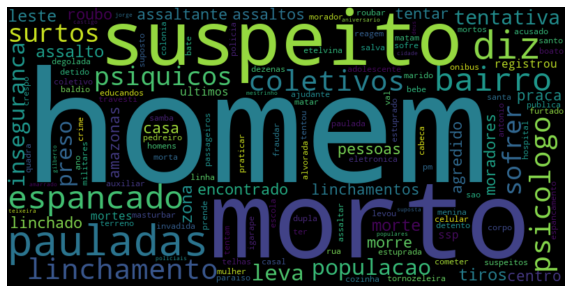

In [ ]:
gerarNuvem(frequenciaTitulo)

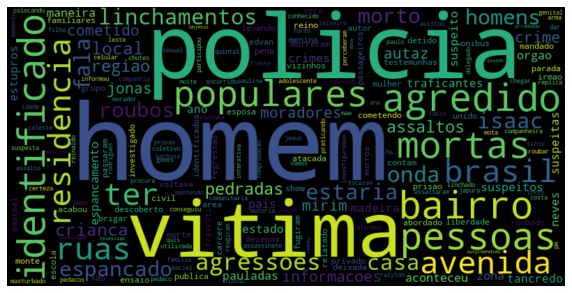

In [ ]:
gerarNuvem(frequenciaSubTitulo)

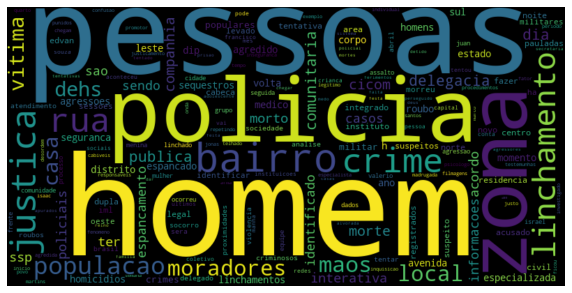

In [ ]:
gerarNuvem(frequenciaMateria)